# Esdudando e explorando dados com NumPy

__Autoria:__ Sabrina Paes Leme P. Correa <br>
__Criação:__ 16/06/2024 <br>
__Modificação:__ 16/06/2024

__Dificuldade:__ Fácil <br>
__Descrição:__ Neste tutorial vamos mostrar algumas funcionalidades com o NumPy para trabalhar com as imagens
<br>
__Referências:__
* https://rasterio.readthedocs.io/en/latest/topics/plotting.html
* https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html
<br>
<br>


__Contato:__ <br>
📧 paeslemesa@gmail.com <br>
🔗 https://www.linkedin.com/in/paeslemesa/?locale=pt_BR <br>
🐱 https://github.com/paeslemesa

## Importando bibliotecas e Determinando nossa entrada de dados

In [1]:
from pathlib import Path #biblioteca de manipulação de arquivos

import numpy as np #biblioteca de manipulação de arrays
import rasterio as rio #biblioteca de manipulação de imagens
from rasterio.plot import show #biblioteca de plotagem de imagens

import matplotlib.pyplot as plt # biblioteca de plotagem de gráficos


from skimage.filters import threshold_otsu

Vamos trabalhar com uma imagem do sensor MSI/Sentinel-2

In [2]:
wkdir = "./"

img_path = Path( wkdir, "SENTINEL2_20240528T004709_20240528T004704_T54MYV.tif")

🌍 Essa imagem é uma imagem de um deslizamente de terra que aconteceu na Papua Nova Guiné em maio de 2024. Foram mais de 500m de deslizamento. E o nosso objetivo vai ser tentar separar informações de solo com floresta nesta imagem para detectar a área do desastre. <br>
Por mais que haja várias e várias ferramentas e até ferramentas super complexas, às vezes precisamos gerar dados de forma muito rápida para auxiliar na tomada de decisões de forma emerngencial. Esse seria um desses casos.

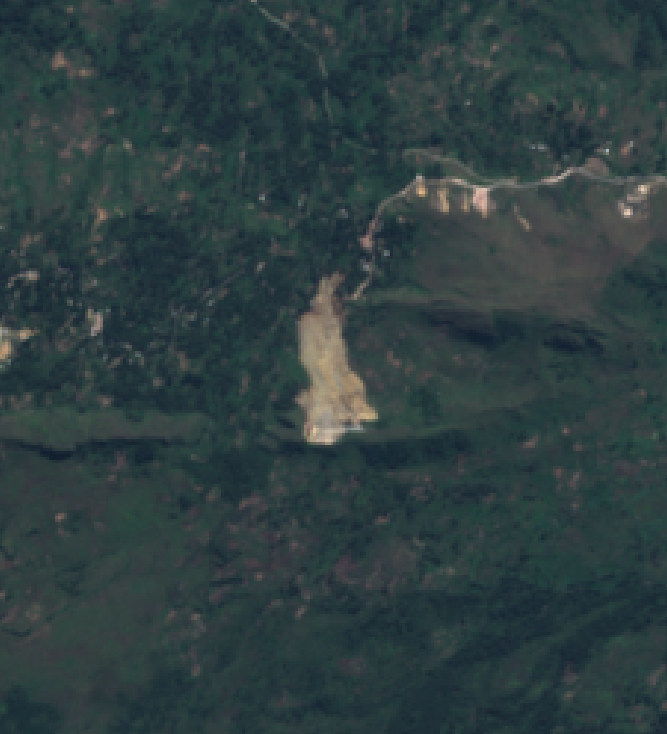

In [3]:
# Abrindo a imagem com o rasterio

with rio.open(img_path) as src:
    img_data = src.read()/10000 #dividindo por 10000 para normalizar os valores do Sentinel-2
    img_perfil = src.profile #pegando o perfil da imagem

Agora, para visualizarmos a imagem e o histograma, podemos criar os gráficos abaixo,

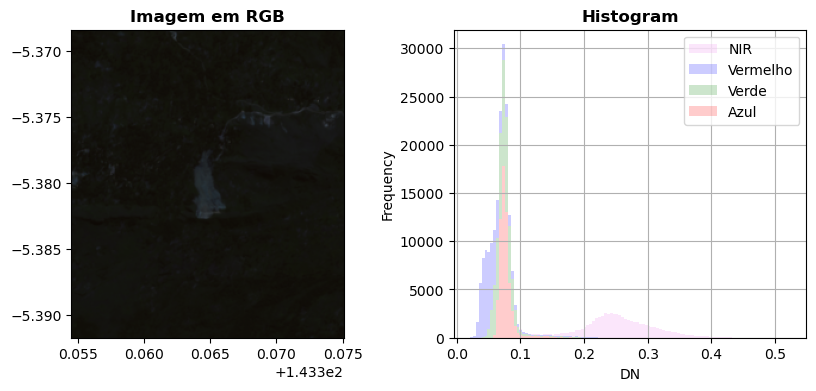

In [21]:
# Primeiro determinamos o que vamos plotar. Aqui determinamos duas imagens e o tamanho total vai ser de 10x4
fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(10,4)) 

# Ajustando primeiro plot
show(img_data[:3, :, :],   # plotando as bandas 0, 1 e 2
     transform=img_perfil['transform'], # pegando a transformação da imagem para a imagem ser plotada corretamente
     title="Imagem em RGB", # título do plot
     ax=axrgb) # plotando no eixo axrgb

rio.plot.show_hist(img_data, # determinando os dados para plotar o histograma
                   bins=110, # aqui nós escolhemos a quantidade de grupos que vamos dividir nossos dados para faciliat visialização. Quanto maior, mais perto da realidade
                   histtype='stepfilled', # tipo de plotagem do histograma
                   lw=0.2, # largura da linha
                   stacked=True, # se queremos os histogramas empilhados ou não
                   alpha=0.2, # transparência dos histogramas
                   ax=axhist, # plotando no eixo axhist
                   label = ['Azul', 'Verde', 'Vermelho', 'NIR']) # determinando os nomes das bandas

# Análise da imagem

🤔 Como estamos trabalhando com um local de vegetação e solo, a primeira coisa que eu faço é calcular o NDVI (_Normalized Differential Vegetation Index_) da imagem.

$NDVI = \frac{NIR-RED}{NIR+RED}$

In [5]:
ndvi = (img_data[3, :, :] - img_data[0, :, :]) / (img_data[3, :, :] + img_data[0, :, :]) # calculando o NDVI

Depois de calcular o NDVI, podemos analisar por imagem mesmo os valores de NDVI da nossa área de estudo.

Text(0.5, 1.0, 'NDVI')

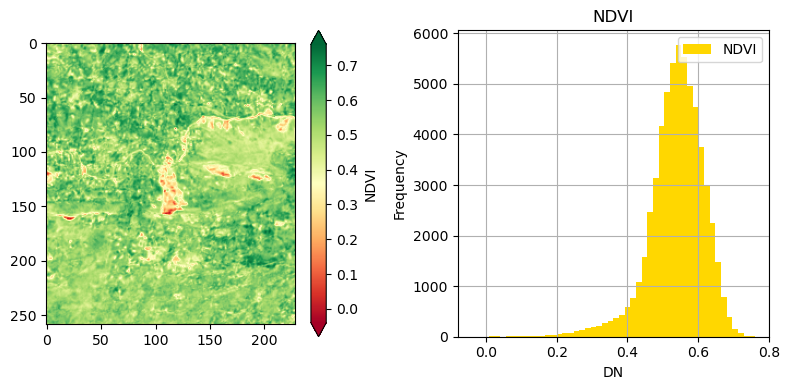

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)
image = ax[0].imshow(ndvi, cmap='RdYlGn')

fig.colorbar(image, ax=ax[0], extend = 'both', label='NDVI', cmap='RdYlGn')


rio.plot.show_hist(ndvi, # determinando os dados para plotar o histograma
                   bins=50, # aqui nós escolhemos a quantidade de grupos que vamos dividir nossos dados para faciliat visialização. Quanto maior, mais perto da realidade
                   #histtype='stepfilled', # tipo de plotagem do histograma
                   lw=0.2, # largura da linha
                   #stacked=True, # se queremos os histogramas empilhados ou não
                   #alpha=0.2, # transparência dos histogramas
                   ax=ax[1], # plotando no eixo axhist
                   label = ['NDVI']) # determinando os nomes das bandas

plt.title('NDVI')


🧠 Agora, analisandoa imagem e o histograma, a gente consegue perceber que valores em torno de <code>NDVI = 0.35</code> são o que separam áreas de solo exposto (vermelho) e floresta (verde)

Text(0.5, 1.0, 'NDVI binário')

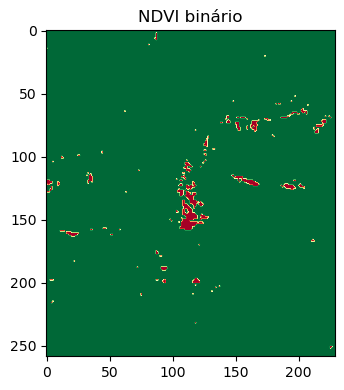

In [7]:
# Vamos testar então valores de NDVI para separar nossos dados em vegetação e solo
limiar = 0.3

# Criando uma imagem binária com base no NDVI, ou seja, onde o NDVI é maior que o limiar, a imagem binária será 1, onde não, será 0
binario = ndvi > limiar

# Plotando a imagem binária para ver se o limiar está coerente
fig, ax = plt.subplots(1, 1, figsize=(4,4), tight_layout=True)
image = ax.imshow(binario, cmap='RdYlGn')

plt.title('NDVI binário')

🔦 Essa imagem binária já pode ser entendida como uma imagem classificada entre Solo e Vegetação e se quisermos já exportar esses dados, já é considerado um resultado.

## Aplicando o filtro na imagem

🧭 Vamos usar a imagem binária de máscara para filtrar nossa imagem.

Para filtrar com numpy, eu gosto de usar o <code>np.where</code>. Essa função funciona assim "aonde essa condição é verdadeira, então valor 1, senão, valor 2".

Com os dados separados, a gente consegue estudar sobre a resposta espectral do solo nessa área (ou da vegetação também, se quisermos).

### Analisando Solo 🏜️

Vamos primeiro olhar como se comportam os dados de solo da nossa imagem. A partir dos dados filtrados, a gente consegue analisar os histogramas e analisando esses histogramas, conseguimos entender melhor a reposta espectral desses dois tipos de alvos.

Primeiro no caso do solo, dá pra olhar que as bandas são mais espalhadas em relação aos níveis digitais (DN).

Text(0.5, 1.0, 'Histograma da imagem filtrada - solo')

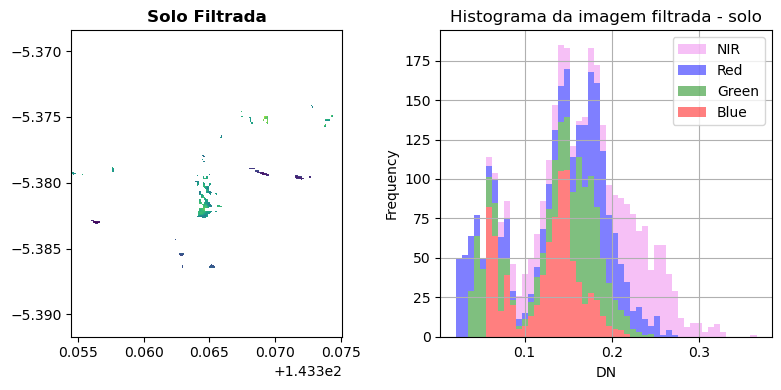

In [18]:

imagm_filtrada = np.where(binario ==0, # aonde a imagem binária é 0
                          img_data, # aonde a condição for verdadeira, o valor será o mesmo da imagem original
                          np.nan) # aonde a condição for falsa, o valor será "nulo"

fig, ax = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)


# Ajustando primeiro plot
show(imagm_filtrada[3, :, :],   # plotando as bandas 3 (NIR)
     transform=img_perfil['transform'], # pegando a transformação da imagem para a imagem ser plotada corretamente
     title="Solo Filtrada", # título do plot
     ax=ax[0]) # plotando no eixo axrgb

rio.plot.show_hist(imagm_filtrada, # determinando os dados para plotar o histograma
                   bins=50, # aqui nós escolhemos a quantidade de grupos que vamos dividir nossos dados para faciliat visialização. Quanto maior, mais perto da realidade
                   histtype='stepfilled', # tipo de plotagem do histograma
                   lw=0.2, # largura da linha
                   stacked=True, # se queremos os histogramas empilhados ou não
                   alpha=0.5, # transparência dos histogramas
                   ax=ax[1], # plotando no eixo axhist
                   label = ['Azul', 'Verde', 'Vermelho', 'NIR']) # determinando os nomes das bandas

plt.title('Histograma da imagem filtrada - solo')

### Análide da Vegetação 🌵

Já no caso da vegetação, dá pra observsr que  os valores das bandas já ficam mais expremidos ali entre 0 e 0.1, com exceção do NIR.
Os valores de NIR tem maior variação porque reflete bastante a clorofila da vegetação.

Text(0.5, 1.0, 'Histograma da imagem filtrada - solo')

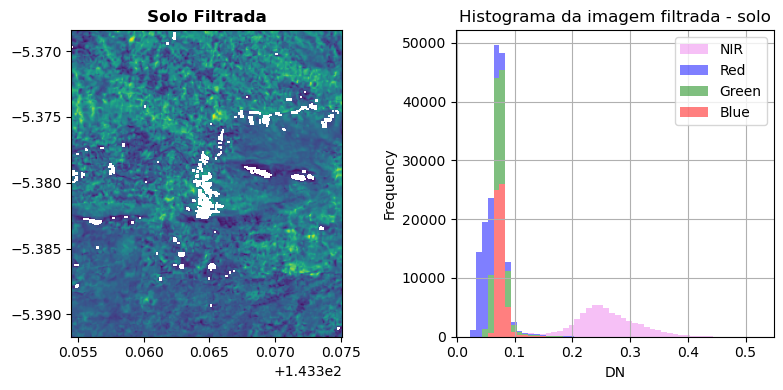

In [19]:
imagm_filtrada = np.where(binario ==1, # aonde a imagem binária é 1
                          img_data, # aonde a condição for verdadeira, o valor será o mesmo da imagem original
                          np.nan) # aonde a condição for falsa, o valor será "nulo"

fig, ax = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)


# Ajustando primeiro plot
show(imagm_filtrada[3, :, :],   # plotando as bandas 3 (NIR)
     transform=img_perfil['transform'], # pegando a transformação da imagem para a imagem ser plotada corretamente
     title="Vegetação Filtrada", # título do plot
     ax=ax[0]) # plotando no eixo axrgb

rio.plot.show_hist(imagm_filtrada, # determinando os dados para plotar o histograma
                   bins=50, # aqui nós escolhemos a quantidade de grupos que vamos dividir nossos dados para faciliat visialização. Quanto maior, mais perto da realidade
                   histtype='stepfilled', # tipo de plotagem do histograma
                   lw=0.2, # largura da linha
                   stacked=True, # se queremos os histogramas empilhados ou não
                   alpha=0.5, # transparência dos histogramas
                   ax=ax[1], # plotando no eixo axhist
                   label = ['Blue', 'Green', 'Red', 'NIR']) # determinando os nomes das bandas

plt.title('Histograma da imagem filtrada - vegetação')

In [11]:
# Salvando a imagem filtrada
caminho_saida = Path(wkdir, f"{img_path}_NDVI_filtrado.tif")

with rio.open(caminho_saida, 'w', **img_perfil) as dst:
    dst.write(imagm_filtrada.astype(rio.float32) * 10000) # multiplicando por 10000 para voltar ao valor original do Sentinel-2